In [1]:
import matplotlib.pyplot as plt
import torch
from pytao import Tao
from bmadx.plot import plot_projections
from bmadx.coordinates import save_as_h5
from phase_space_reconstruction.virtual.beamlines import quad_tdc_bend

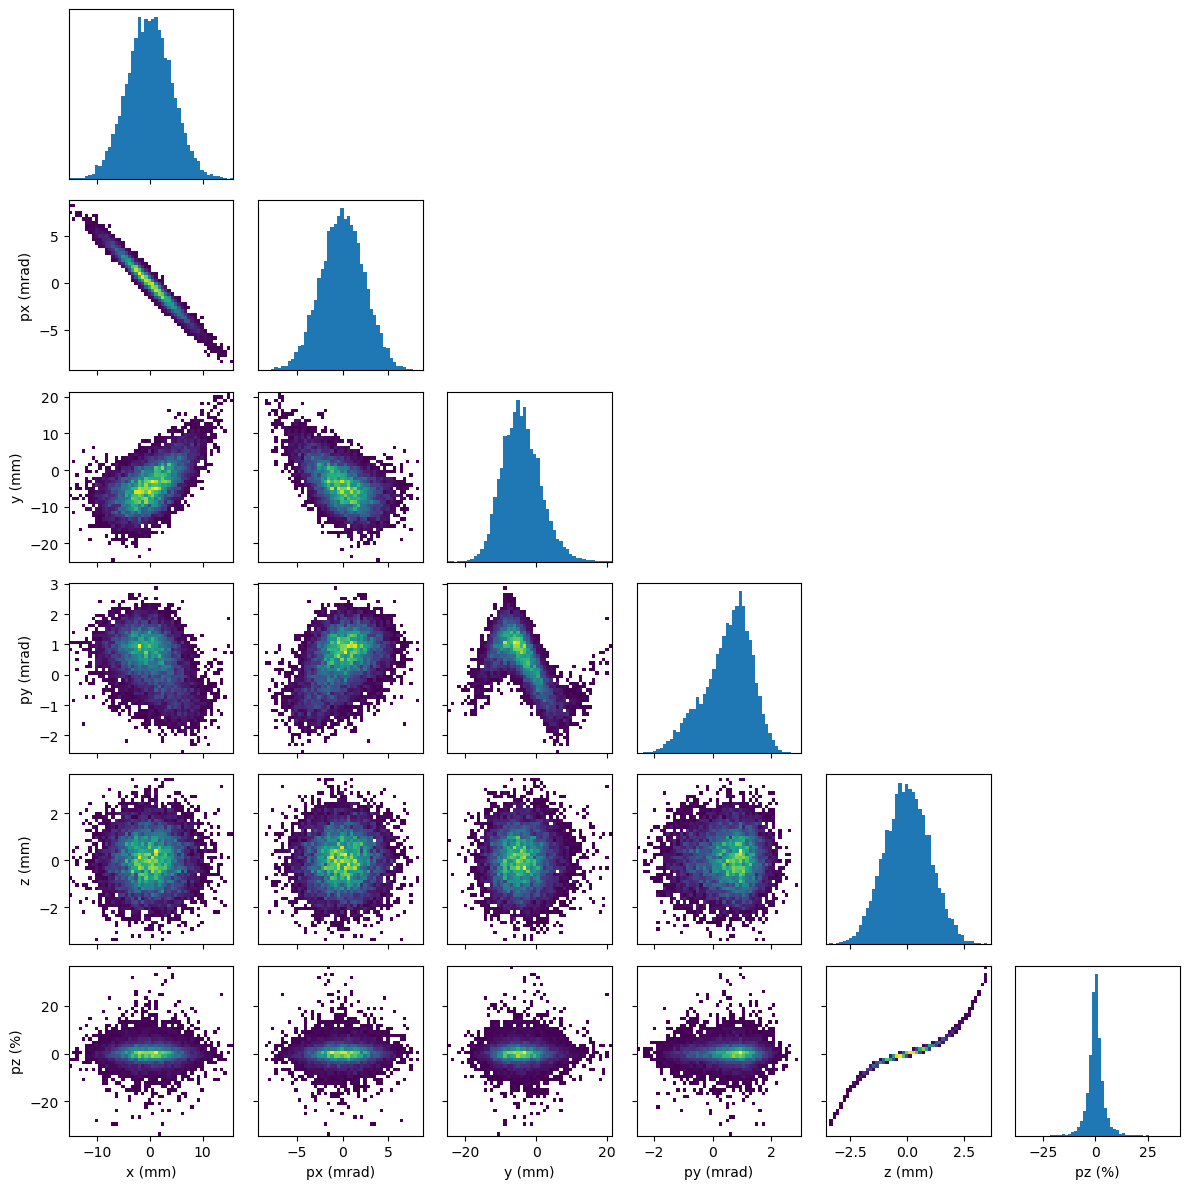

In [2]:
gt_beam = torch.load('data/gt_beam.pt')
fig, ax = plot_projections(gt_beam.numpy_particles())
plt.show()

In [6]:
save_as_h5(gt_beam.numpy_particles(), 'pmd_beam.h5')

In [8]:
tao = Tao('-init tao.init -noplot')
tao.cmd('set global track_type = beam')
x_ini = tao.bunch1('beginning', 'x')
px_ini = tao.bunch1('beginning', 'px')
y_ini = tao.bunch1('beginning', 'y')
py_ini = tao.bunch1('beginning', 'py')
z_ini = tao.bunch1('beginning', 'z')
pz_ini = tao.bunch1('beginning', 'pz')


In [11]:
x_end = tao.bunch1('end', 'x')
px_end = tao.bunch1('end', 'px')
y_end = tao.bunch1('end', 'y')
py_end = tao.bunch1('end', 'py')
z_end = tao.bunch1('end', 'z')
pz_end = tao.bunch1('end', 'pz')

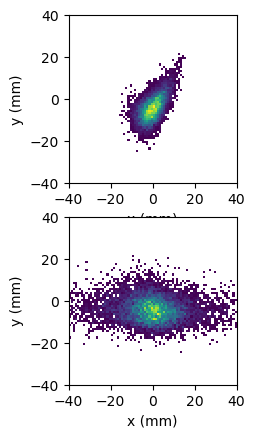

In [27]:
fig, ax = plt.subplots(2,1)
mycmap = plt.get_cmap('viridis') # viridis plasma inferno magma and _r versions
mycmap.set_under(color='white') # map 0 to this color
myvmin = 1 # something tiny
# Bin particles
ax[0].hist2d(x=1000*x_ini, y=1000*y_ini,  bins=[80,80], range=[[-40,40],[-40,40]] ,cmap=mycmap, vmin=myvmin)
ax[0].set_xlabel('x (mm)')
ax[0].set_ylabel('y (mm)')
ax[0].set_aspect('equal')
ax[1].hist2d(x=1000*x_end, y=1000*y_ini,  bins=[80,80], range=[[-40,40],[-40,40]] ,cmap=mycmap, vmin=myvmin)
ax[1].set_xlabel('x (mm)')
ax[1].set_ylabel('y (mm)')
ax[1].set_aspect('equal')
plt.show()

In [22]:
# diagnostic beamline:
p0c = 43.36e6
lattice = quad_tdc_bend(p0c)
lattice.elements[0].K1.data = torch.tensor(0)
lattice.elements[2].VOLTAGE.data = torch.tensor(0)
beam_out = lattice(gt_beam)

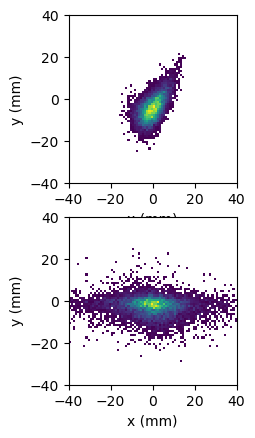

In [25]:
fig, ax = plt.subplots(2,1)
mycmap = plt.get_cmap('viridis') # viridis plasma inferno magma and _r versions
mycmap.set_under(color='white') # map 0 to this color
myvmin = 1 # something tiny
# Bin particles
ax[0].hist2d(x=1000*gt_beam.x, y=1000*gt_beam.y,  bins=[80,80], range=[[-40,40],[-40,40]] ,cmap=mycmap, vmin=myvmin)
ax[0].set_xlabel('x (mm)')
ax[0].set_ylabel('y (mm)')
ax[0].set_aspect('equal')
ax[1].hist2d(x=1000*beam_out.x, y=1000*beam_out.y,  bins=[80,80], range=[[-40,40],[-40,40]] ,cmap=mycmap, vmin=myvmin)
ax[1].set_xlabel('x (mm)')
ax[1].set_ylabel('y (mm)')
ax[1].set_aspect('equal')
plt.show()

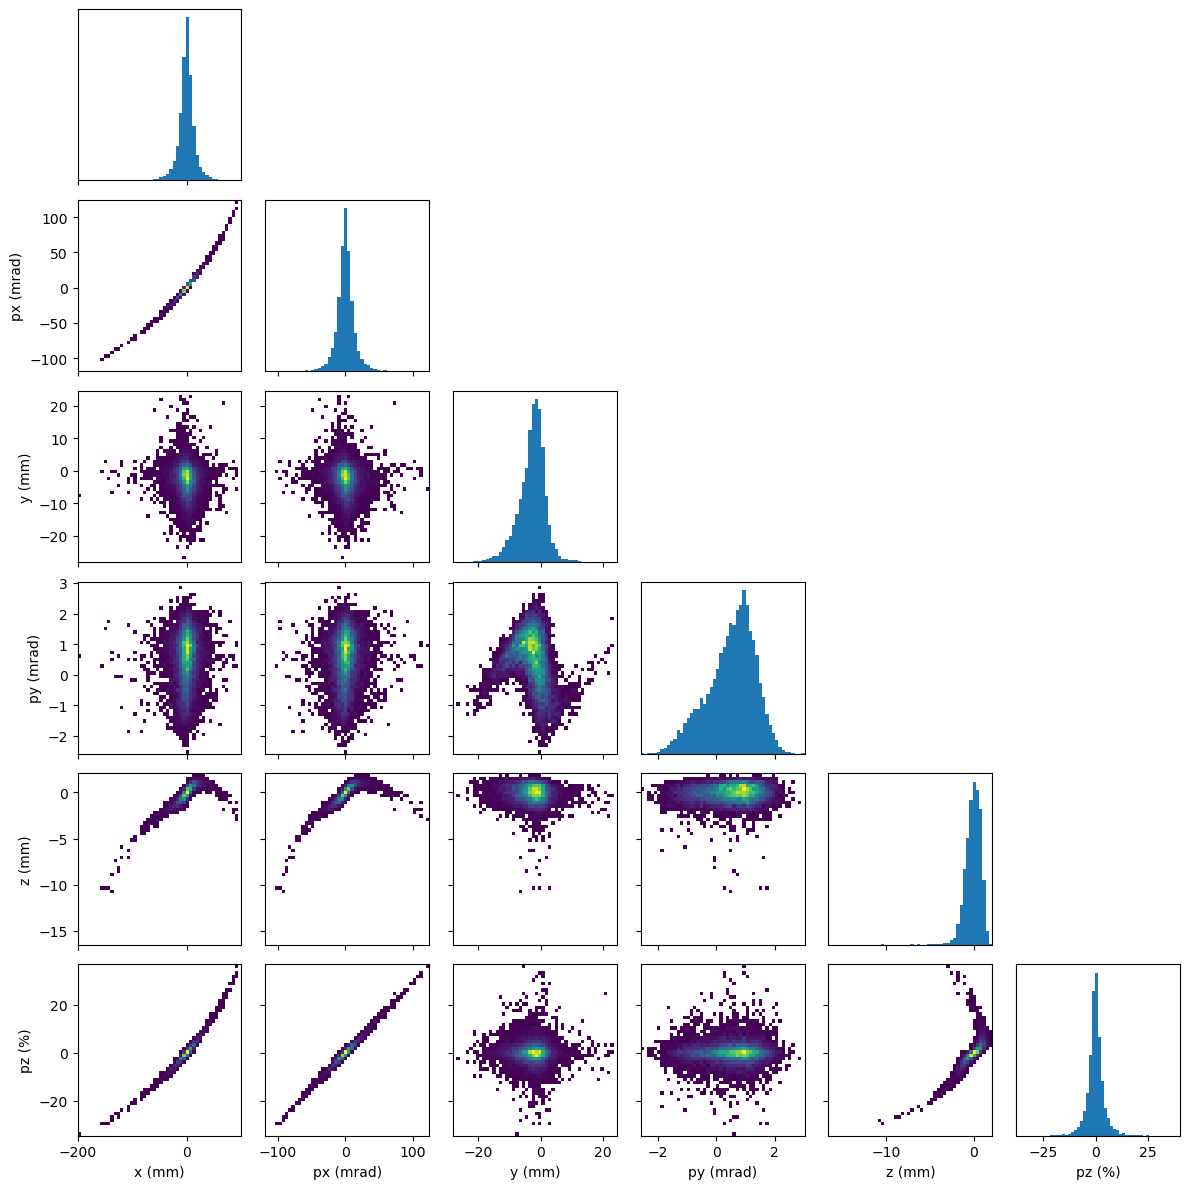

In [21]:
fig, ax = plot_projections(beam_out)
plt.show()

In [28]:
data_dir = 'data'

In [60]:
from phase_space_reconstruction.diagnostics import ImageDiagnostic
from phase_space_reconstruction.virtual.scans import run_quad_scan
from phase_space_reconstruction.analysis import plot_scan_data, plot_predicted_screens
from phase_space_reconstruction.train import train_1d_scan
import os

# quadrupole strengths for scan (reshape as: n_quad_strengths x n_images_per_quad_strength x 1)
n_ks = 20
ks = torch.linspace(-10, 10, n_ks).reshape((n_ks,1,1))

# split in training and testing sets
train_ks = ks[::2]
test_ks = ks[1::2]

# create diagnostic screen: 
bins = torch.linspace(-40, 40, 200) * 1e-3
bandwidth = (bins[1]-bins[0]) / 2
screen = ImageDiagnostic(bins, bins, bandwidth)

/home/jp/Repositories/PS-Reconstruction/phase_space_reconstruction/phase_space_reconstruction/diagnostics.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer("bandwidth", torch.tensor(bandwidth))


In [61]:
# generate and save train and test datasets
train_dset = run_quad_scan(gt_beam, lattice, screen, train_ks, save_as=os.path.join('data', 'train.dset'))
test_dset = run_quad_scan(gt_beam, lattice, screen, test_ks, save_as=os.path.join('data', 'test.dset'))
print(train_dset.k.shape)
print(train_dset.images.shape)


dataset saved as 'data/train.dset'
dataset saved as 'data/test.dset'
torch.Size([10, 1, 1])
torch.Size([10, 1, 200, 200])


data
k = tensor([1.5789]) 1/m$^2$


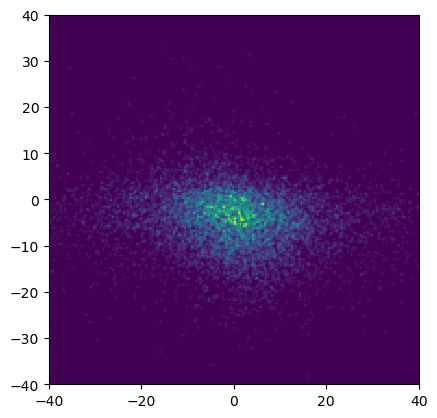

In [62]:
import numpy as np
i_k = 5
print('data')
print(f'k = {test_dset.k[i_k,0]} 1/m$^2$')
extent = np.array([bins[0], bins[-1], bins[0], bins[-1]])*1e3
plt.imshow(test_dset.images[i_k,0,:,:].T, 
            origin = 'lower',
            extent = extent,
            interpolation = 'none')

plt.show()

image size = 80 x 80 mm
test samples boxed in orange


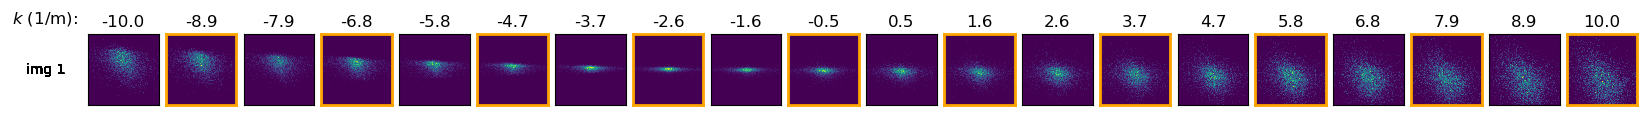

In [63]:
# plot generated datasets
fig, ax = plot_scan_data(train_dset, test_dset, bins, bins)
plt.show()

In [64]:
# training
pred_beam = train_1d_scan(train_dset, lattice, p0c, screen, n_epochs=1000, device='cuda')

Using device: cuda
0 tensor(4509105., device='cuda:0', grad_fn=<MulBackward0>)
100 tensor(1593814.8750, device='cuda:0', grad_fn=<MulBackward0>)
200 tensor(1607899.5000, device='cuda:0', grad_fn=<MulBackward0>)
300 tensor(1560211.6250, device='cuda:0', grad_fn=<MulBackward0>)
400 tensor(1584627.3750, device='cuda:0', grad_fn=<MulBackward0>)


In [65]:
# predicted screens:
pred_dset = run_quad_scan(pred_beam, lattice, screen, ks)

image size = 80 x 80 mm
test samples boxed in orange


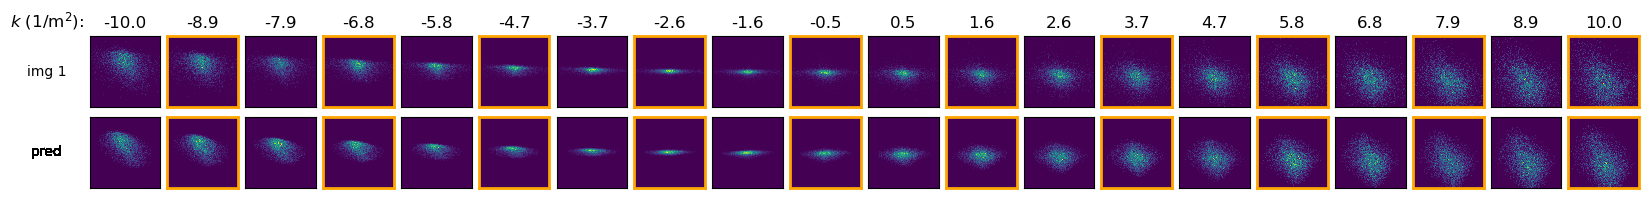

In [66]:
# compare predicted screens with data
fig, ax = plot_predicted_screens(pred_dset, train_dset, test_dset, bins, bins)
plt.show()

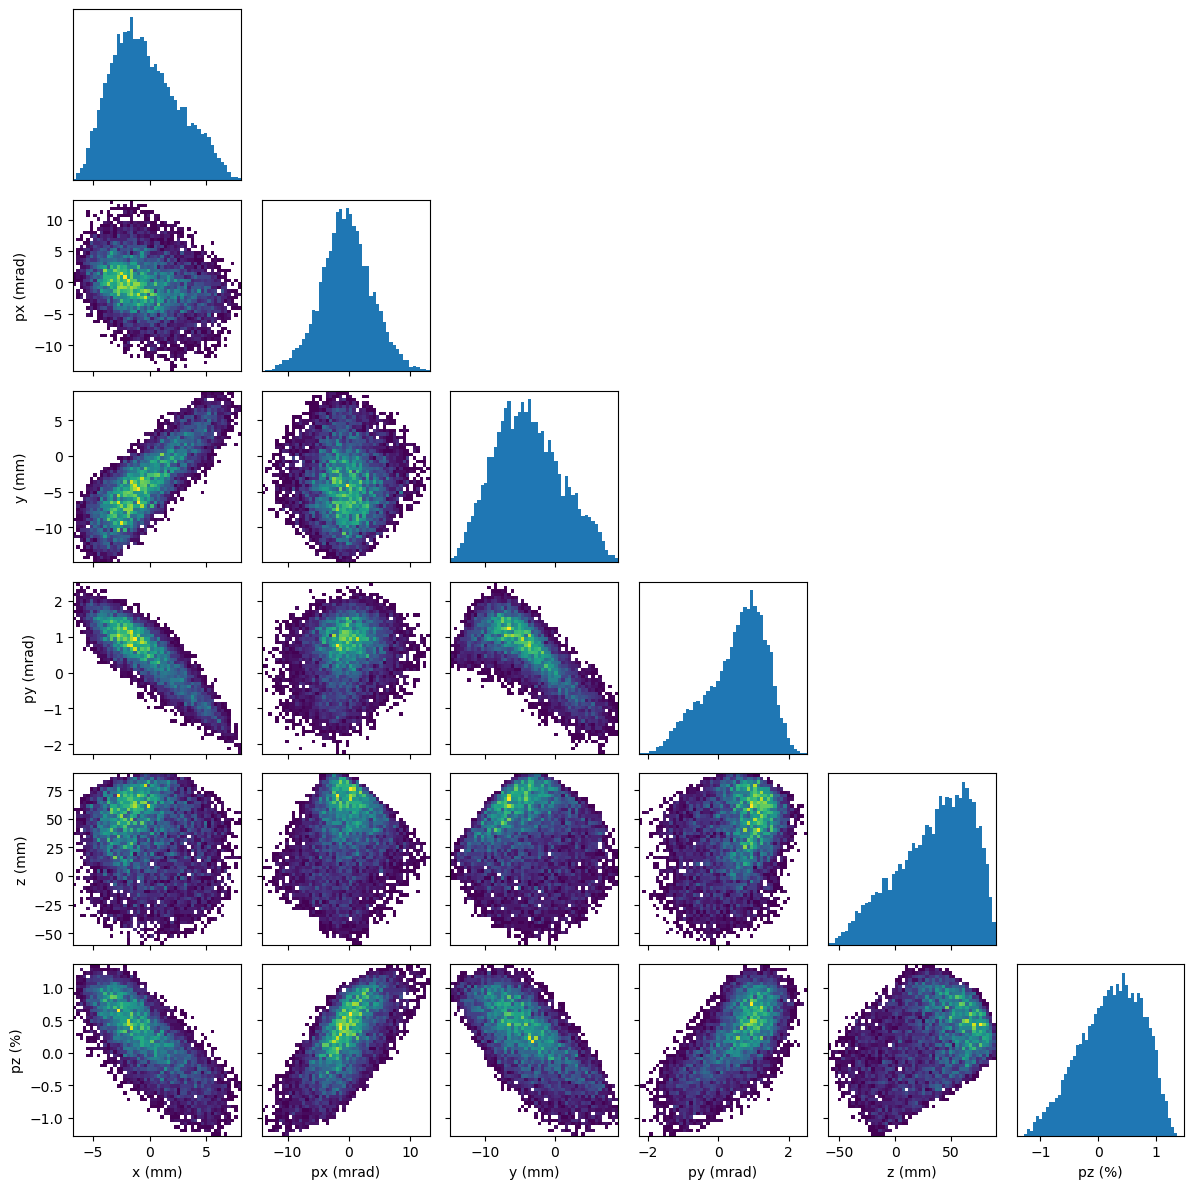

In [69]:
# reconstructed beam projections: 
fig, ax = plot_projections(pred_beam.numpy_particles()
                           )
plt.show()

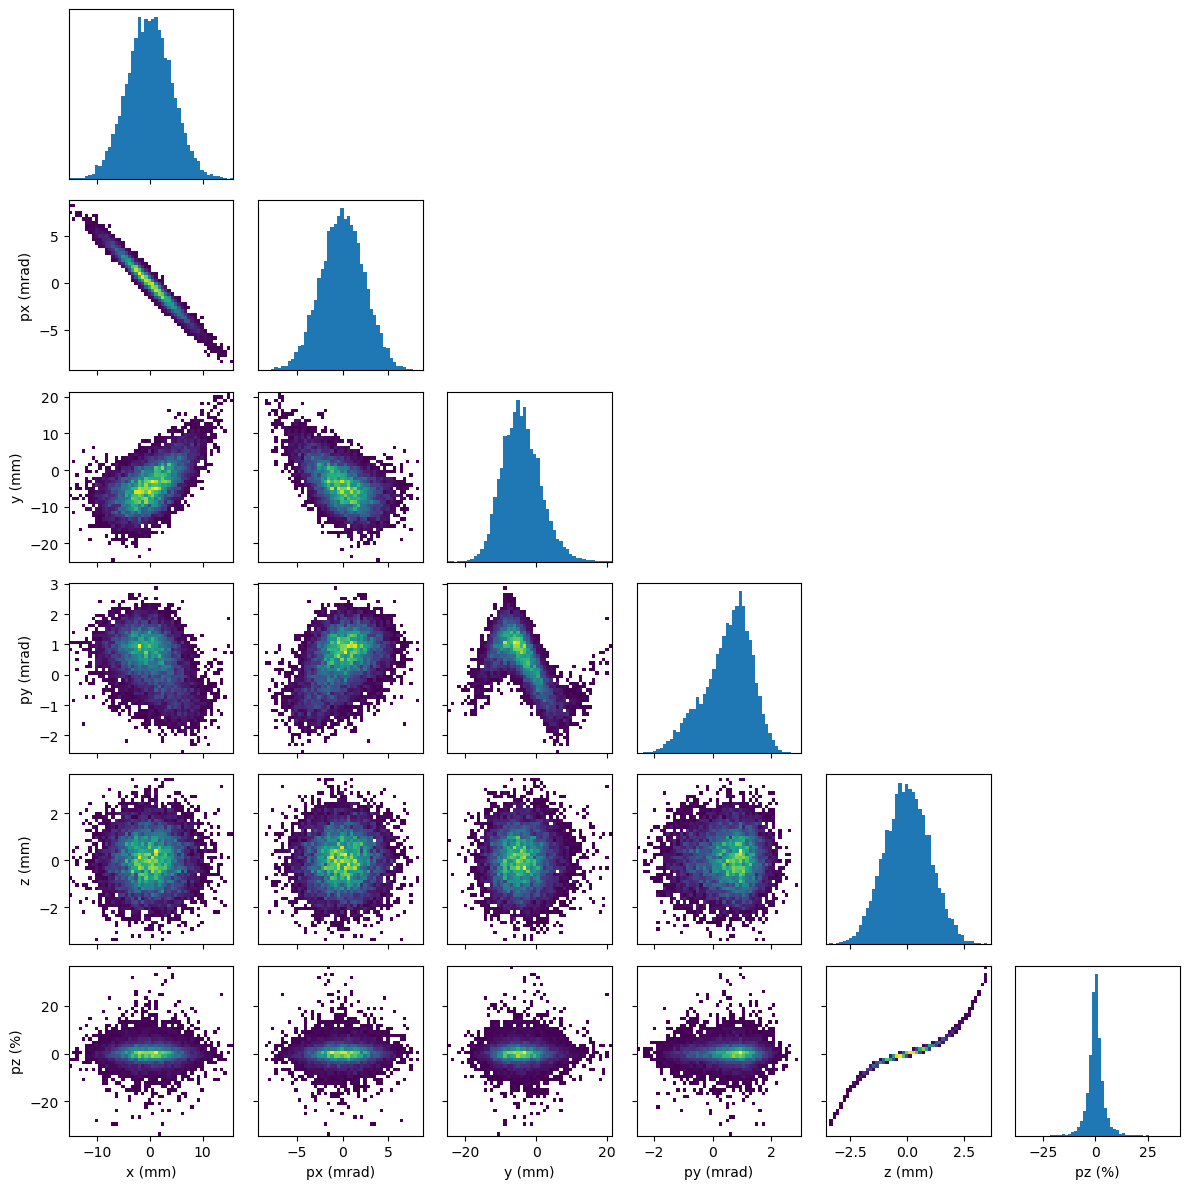

In [71]:
# ground truth beam projections:
fig, ax = plot_projections(gt_beam.numpy_particles())
plt.show()